<a href="https://colab.research.google.com/github/r-isachenko/2024-DGM-MIPT-YSDA-course/seminars/seminar4/seminar4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import os
import sys
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

<!-- <center><img src="data:image/png;base64," width=500 /></center> -->

# <center>Deep Generative Models</center>
## <center>Seminar 4</center>

<center>14.10.2024</center>


## Plan

1. Latent Variable Modeling

    - Gaussian Mixture Models (GMM)
    
    - MLE for GMM
    
2. ELBO and EM - algorithm. 
    
    - EM algorithms for GMM (theory and practice)
    

## Latent Variables Model

What do you remember about it?

<center>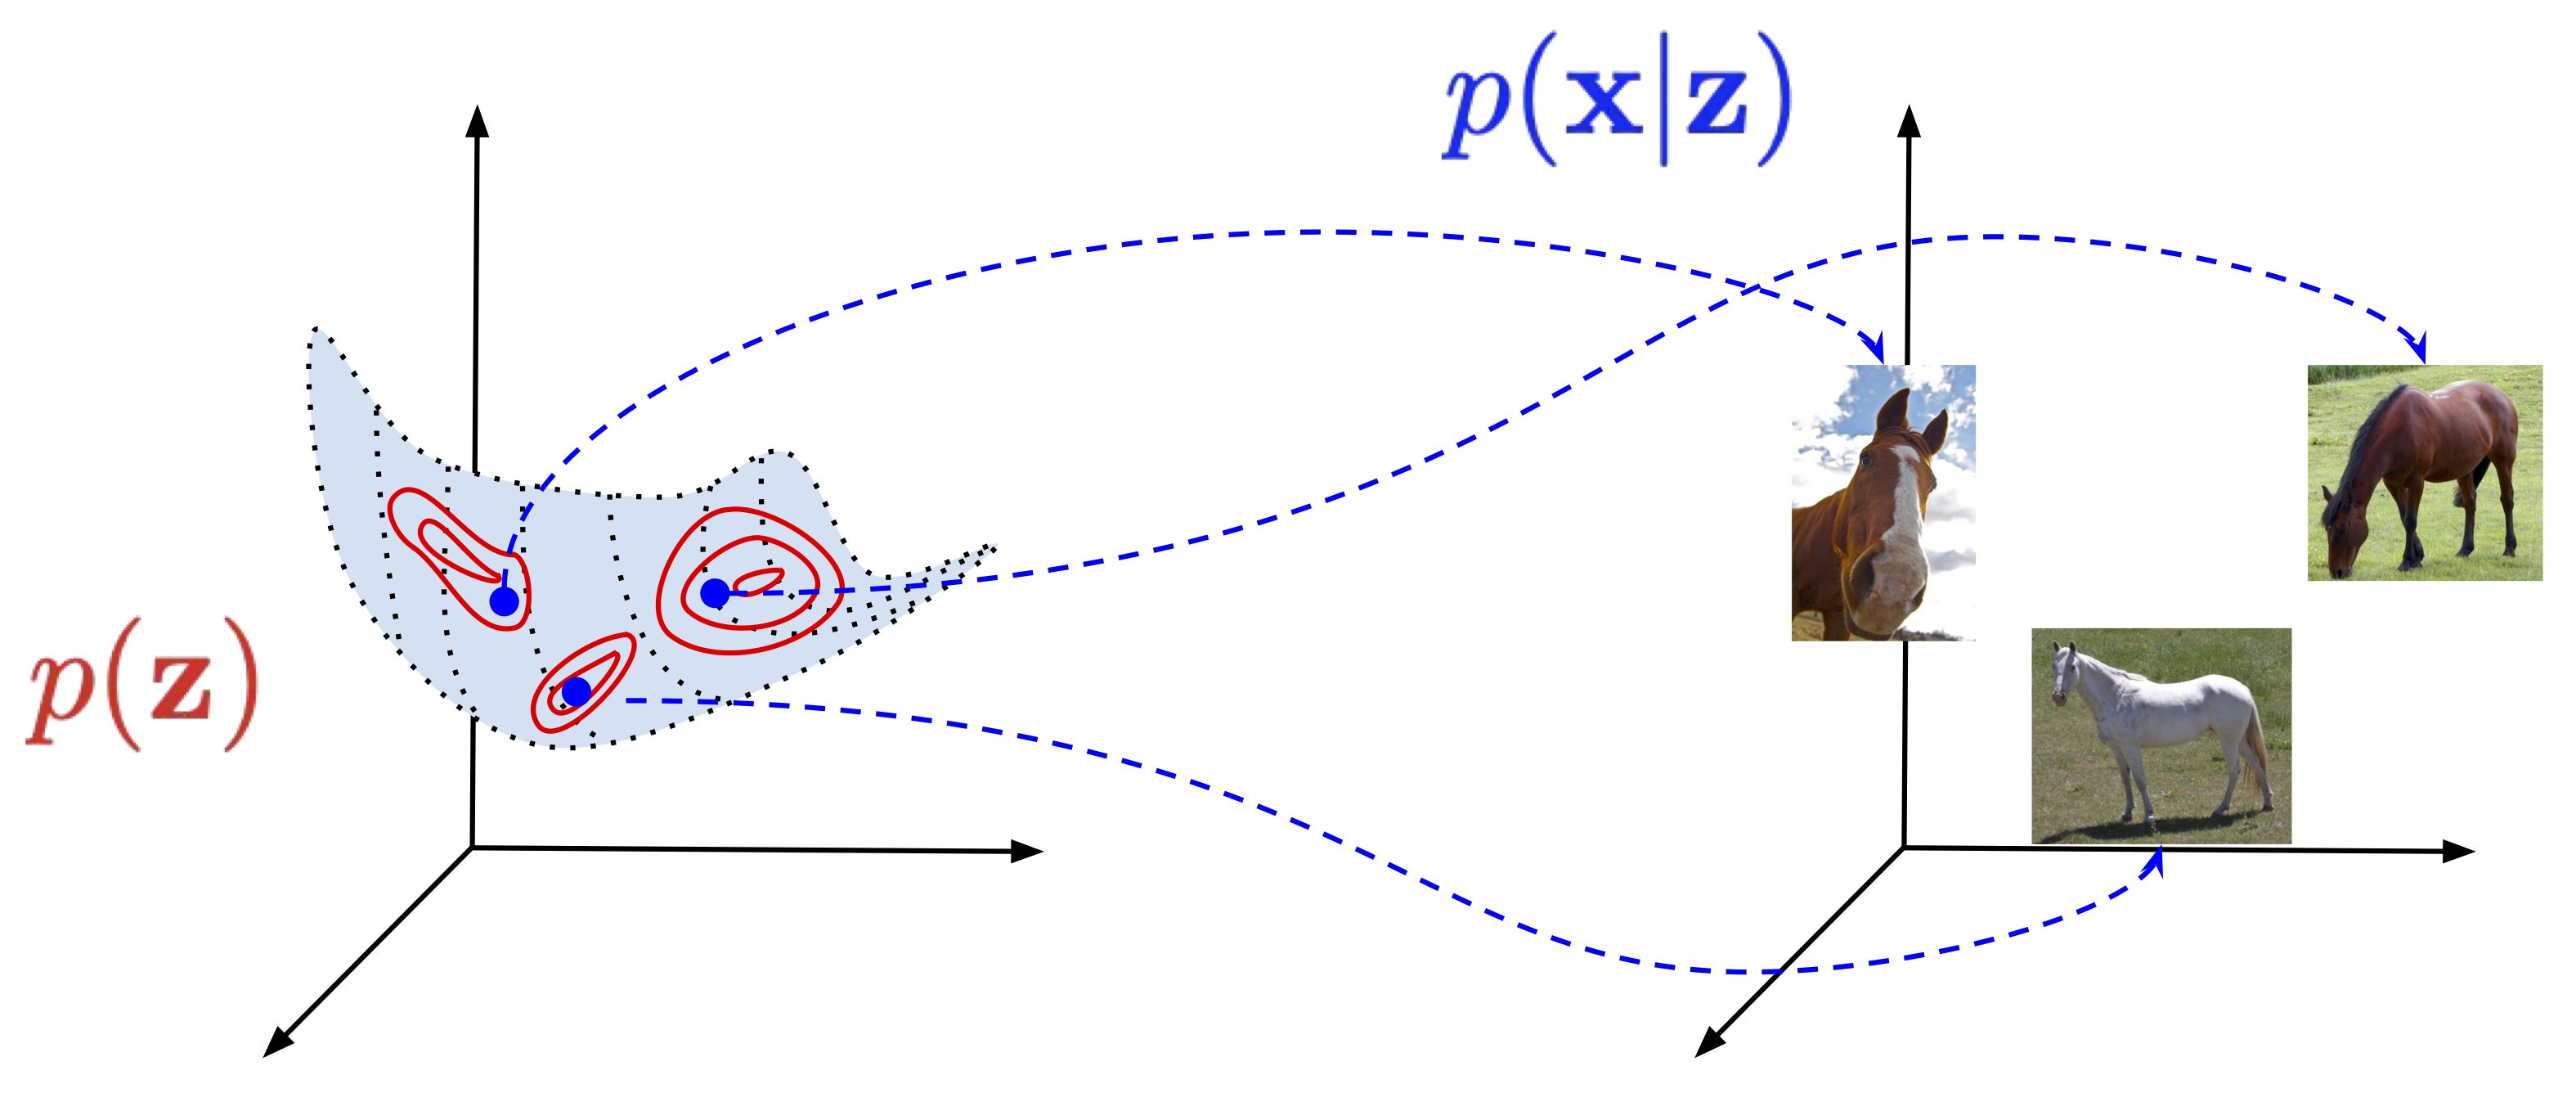</center>

**Likelihood**

$p(x |\theta) = \int\limits_{\mathcal{Z}} p(x | z, \theta) p(z| \theta) dz$

**Sampling procedure**

* Sample $z^* \sim p(z | \theta)$

* Sample $x \sim p(x | z^*, \theta)$

**Question** 

$p(x) = \int p(x|z)p(z)dz = \mathbb{E}_{z\sim p(z)} p(x|z) \approx \dfrac{1}{K}\sum_k p(x|z_k)$. 

Problems?

### Gaussian Mixture Models

$p(z | \theta) = \text{Categorical}(\pi_1, \dots \pi_K)$

$p(\boldsymbol{x} | z, \theta) = \mathcal{N}\left(\boldsymbol{x}|, \boldsymbol{\mu}_z, \boldsymbol{\Sigma}_z\right)$

**Likelihood** of the model?

$p(x | \theta) = \sum\limits_{k = 1}^{K}  \pi_k \mathcal{N}\left(x | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\right)$

Loading `dgm_utils` for colab users

In [ ]:
# colab dgm_utils install
COMMIT_HASH = "f248183c31ac030c81031ae2d2f1a1c42e3a197b"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Loading `dgm_utils` from local

In [2]:
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

**Note:** Можно создавать параметры модели следующим образом!: 

```python
self.param = nn.Parameter(param)
```

Поскольку  `__setattr__` переопредлён!

In [11]:
class GMM(nn.Module):
    
    @property
    def mu(self):
        return self._mu
    
    @mu.setter
    def mu(self, val):
        self._mu = nn.Parameter(val)

    @property
    def sigma(self):
        # The covariance matrix is a positive definite matrix
        return self._L @ self._L.transpose(1, 2)
    
    @sigma.setter
    def sigma(self, val):
        self._L = nn.Parameter(torch.cholesky(val))

    @property
    def pi(self):
        return F.softmax(self._log_pi)

    @pi.setter
    def pi(self, val):
        assert val.min() > 0.
        val = val/torch.sum(val)
        self._log_pi = nn.Parameter(torch.log(val))

    @property
    def gmm(self):
        # Computational graph issues
        mix = TD.Categorical(self.pi)
        mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self._L)
        gmm = TD.MixtureSameFamily(mix, mv_normals)
        return gmm

    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (K, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (K,)
                       (default) equal value to all cluster i.e. 1/K
        '''
        super().__init__()
        self.K = K
        self.dim = dim
        if mu is None:
            mu = np.random.rand(K, dim)*20 - 10
        self.mu = torch.tensor(mu) # (K, D)
        if sigma is None :
            sigma = np.zeros((K, dim, dim))
            for i in range(K):
                sigma[i] = np.eye(dim)
        self.sigma = torch.tensor(sigma) # (K, D, D)
        assert torch.allclose(self.sigma, torch.tensor(sigma))
        if pi is None:
            pi = np.ones(self.K)/self.K
        self.pi = torch.tensor(pi) # (K,)
        # mix = TD.Categorical(self.pi)
        # mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self.sigma)
        # self.gmm = TD.MixtureSameFamily(mix, mv_normals)
        #self.gmm = TD.MultivariateNormal(self.mu, self.sigma)

    def log_prob(self, X):
        '''
        Compute the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return self.gmm.log_prob(X)

    def prob(self, X):
        '''
        Computes the prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: Sum_k pi_k * N( X_i | mu_k, sigma_k )
        '''
        return torch.exp(self.log_prob(X))
    
    def prob_X_Zs(self, X):
        '''
        Computes the matrix of probabilities p(X, Z | \theta)
        for all possible Z_i \in \{1, 2, \dots K\}
        :Parameters:
        X : tensor (N, D)
        :Output:
        out : tensor (N, K)
        
        P_ik = p(X_i, z=k) = p(X_i|z=k) * p(z=k) = N(X_i| mu_k, sigma_k) * pi_k
        '''
        mv_normals = self.gmm._component_distribution
        X_expanded = X.unsqueeze(-2).repeat(1, self.K, 1) # (N, K, 2)
        log_probs_unw = mv_normals.log_prob(X_expanded) # (N, K)
        log_probs_w = torch.exp(log_probs_unw) * self.pi.unsqueeze(0) # (N, K)
        return log_probs_w

    def sample(self, shape):
        return self.gmm.sample(shape)

GMM visualization

In [12]:
def draw_contour(density, X, Y, title, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels, c='red')
    plt.title(title, fontsize=16)
    plt.show()

def draw_distrib(distrib, title, n_levels=20, x_lim=(-11, 11), y_lim=(-11, 11), dx=0.1, dy=0.1, device=DEVICE, contour=True, density=True):
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = torch.exp(distrib.log_prob(torch.tensor(mesh_xs).to(device))).detach().cpu().numpy()
    if contour:
        draw_contour(densities, x, y, title='{} contour'.format(title), n_levels=20)
    if density:
        visualize_2d_densities(x, y, densities, title='{} pdf'.format(title))

#### Task setup

The distribution we will work with:

In [13]:
class FlowerGMM(GMM):

    def __init__(self):
        CENTERS_SCALE = 6.
        MAJOR_VAR = 3.
        MINOR_VAR = 1.
        r_angles = np.linspace(0., 2 * np.pi, 7, endpoint=False)
        vs = np.array([[np.cos(ang), np.sin(ang)] for ang in r_angles])
        perp_vs = np.array([[-np.sin(ang), np.cos(ang)] for ang in r_angles])
        mus = np.array([[0., 0.],] + [CENTERS_SCALE * v for v in vs])
        R_matrices = np.stack([vs, perp_vs], axis=1)
        petal_sigmas = np.array([[MAJOR_VAR, 0.], [0., MINOR_VAR]])[np.newaxis,...].repeat(7, axis=0)
        sigmas = np.concatenate([
            np.eye(2)[np.newaxis,...], 
            R_matrices.transpose(0, 2, 1) @ petal_sigmas @ R_matrices])
        super().__init__(8, 2, mu=mus, sigma=sigmas)
        # super().__init__(1, 2)

Visualization of `FlowerGMM`

In [ ]:
fgmm = FlowerGMM().to(DEVICE)
draw_distrib(fgmm, 'FlowerGMM')

Reference samples from `FlowerGMM`

In [15]:
torch.manual_seed(42)
train_data = fgmm.sample((20000,)).detach()
test_data = fgmm.sample((2000,)).detach()

In [ ]:
plt.scatter(test_data[:,0], test_data[:,1], marker='.')

**Question.**

How to fit GMM model to data $X_1, \dots X_n$ from unknown distribution?

- One can try likelihood maximization

- EM algorithm (will be explained soon)

### GMM via MLE

Let $X_1, \dots, X_N \sim p(x)$ , $X_i \in \mathbb{R}^D$

**GMM** model likelihood: 

$\log p(\boldsymbol{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum\limits_{n = 1}^{N} \log \left(\sum\limits_{k = 1}^{K}  \pi_k \mathcal{N}\big{(}X_n - \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\big{)}\right)$

Analytical solution is **hard**! $\Rightarrow$ gradient optimization

In [17]:
class GMM_MLEgrad(GMM):

    def loss(self, x):
        # self._project()
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

Initialize a GMM model which will be trained

In [ ]:
np.random.seed(42)
N_COMPONENTS = 12
gmm = GMM_MLEgrad(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

In [ ]:
BATCH_SIZE = 128
LR= 1e-3
EPOCHS = 100
USE_CUDA=False

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

optimizer = optim.Adam(gmm.parameters(), lr=LR)

train_model(
    gmm, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    optimizer=optimizer,
    scheduler=None, 
    device=DEVICE,
    visualize_samples=False
)

In [ ]:
draw_distrib(gmm, 'Trained GMM')

## ELBO

<center>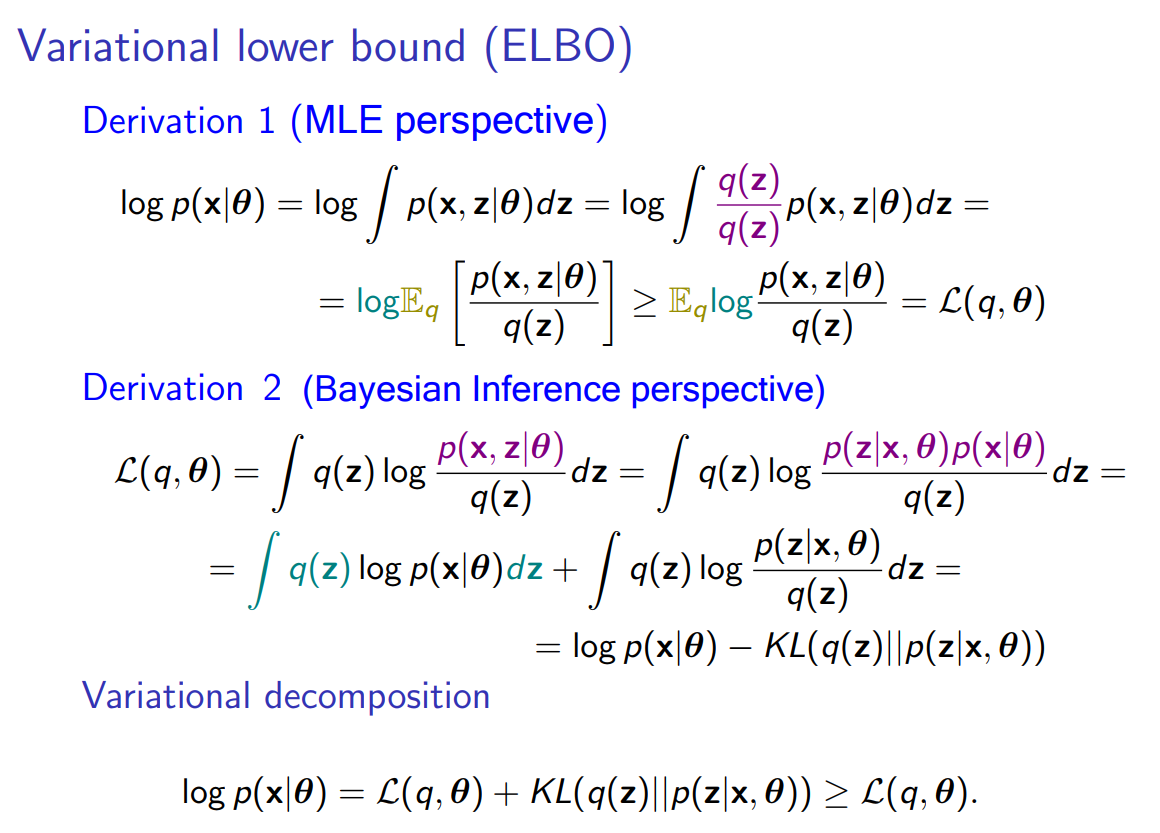</center>

## EM-algorithm

<center>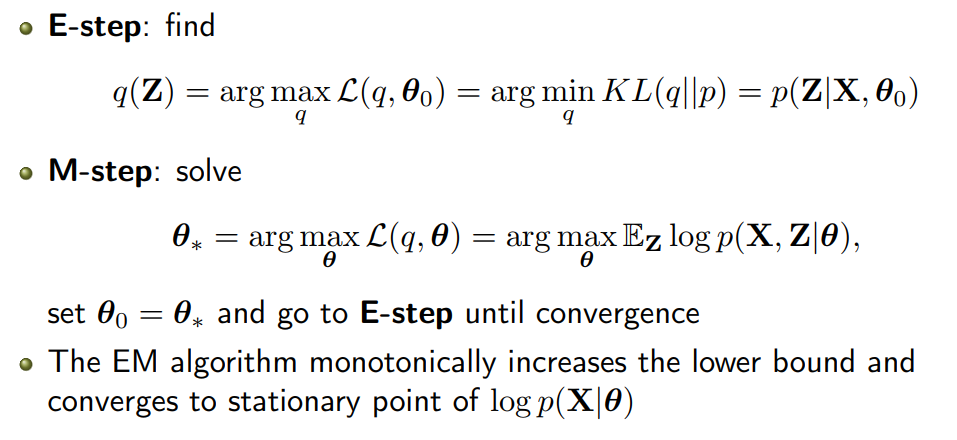</center>

### GMM via EM - algorithm

$\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$

**E-step**

$\xi_{k}^{n} = p\left( \{ z_n = k \} \middle| X_n, \theta^{\text{prev}}\right) = \frac{\pi_k^{\text{prev}} \mathcal{N}\left(\mathbf{x}_n \middle| \boldsymbol{\mu}_k^{\text{prev}}, \boldsymbol{\Sigma}_k^{\text{prev}}\right)}{\sum\limits_{k' = 1}^{K} \pi_{k'}^{\text{prev}} \mathcal{N}\left(\mathbf{x}_n \middle| \boldsymbol{\mu}_{k'}^{\text{prev}}, \boldsymbol{\Sigma}_{k'}^{\text{prev}}\right)}$

**M-step**

$\pi^{\text{new}}_k = \frac{1}{N} \sum\limits_{n = 1}^{N} \xi_k^n \, \in \, (0, 1)$

$\mu^{\text{new}}_k = \frac{1}{\sum\limits_{n = 1}^{N} \xi_k^n} \sum\limits_{n = 1}^{N} \xi_{k}^{n} X_n \, \in \, \mathbb{R}^D$

$\Sigma^{\text{new}}_k = \frac{1}{\sum\limits_{n = 1}^{N} \xi_k^n} \sum\limits_{n = 1}^{N} \xi_{k}^{n} \left(X_n - \mu^{\text{new}}_k\right) \left(X_n - \mu^{\text{new}}_k\right)^T \in \text{PSD}\left(\mathbb{R}^{D \times D}\right)$

In [30]:
# K is number of components in the Gaussian Mixture Model
# N is the number of samples |X|
# D=2 is the dimension of each sample X_n

class GMM_EM(GMM):
    
    def prob_components(self, X):
        '''
        Creates matrix of p(z_k | X_n, \theta)
        :Parameters:
        X : tensor (N, 2) : samples from the target distribution
        '''
        p_x_zs = self.prob_X_Zs(X) # (N, K)
        return p_x_zs / p_x_zs.sum(-1, keepdim=True) # (N, K)
    
    def compute_pi_new(self, prob_components):
        '''
        Computes the paramters \pi_{new} at the M-step of EM algo
        :Parameters:
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        :Output:
        pi_new : tensor (K,) : \pi_{new} 
        '''
        return torch.mean(prob_components, dim=0)
    
    def compute_mu_new(self, X, prob_components):
        '''
        Computes the parameters \mu_{new} at the M-step of EM algo
        :Paramters:
        X : tensor (N, 2) : samples from the target distribution
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        :Output:
        mu_new : tensor (K, 2) : \mu_{new}
        '''
        X_expanded = X.unsqueeze(-2) # (N, 1, 2)
        prob_components_expanded = prob_components.unsqueeze(-1) # (N, K, 1)
        mu_unnorm = torch.sum(X_expanded * prob_components_expanded, dim=0) # (K, 2)
        return mu_unnorm / prob_components_expanded.sum(0)
    
    def compute_sigma_new(self, X, mu_new, prob_components):
        '''
        :Parameters:
        X : tensor (N, 2) : samples from the target distribution
        mu_new : tensor (K, 2) : \mu_{new} from the M-step of EM algo
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        '''
        X_expanded = X.unsqueeze(-2) # (N, 1, 2)
        mu_new_expanded = mu_new.unsqueeze(0) # (1, K, 2)
        X_min_mu = X_expanded - mu_new_expanded # (N, K, 2)
        X_min_mu_expanded = X_min_mu.unsqueeze(-2) # (N, K, 1, 2)
        Cov_grid = X_min_mu_expanded.transpose(-1, -2) @ X_min_mu_expanded # (N, K, 2, 2)
        prob_components_expanded = prob_components.unsqueeze(-1).unsqueeze(-1) # (N, K, 1, 1)
        Sigma_unnorm = torch.sum(prob_components_expanded * Cov_grid, dim=0) # (K, 2, 2)
        return Sigma_unnorm / prob_components_expanded.sum(0)
    
def EM_step(gmm_em, X):
    gmm_em.eval()
    # E step
    with torch.no_grad():
        prob_components = gmm_em.prob_components(X)
    
    # M step
    with torch.no_grad():
        pi_new = gmm_em.compute_pi_new(prob_components)
        mu_new = gmm_em.compute_mu_new(X, prob_components)
        Sigma_new = gmm_em.compute_sigma_new(X, mu_new, prob_components)
    
    # update parameters
    eps=1e-5
    gmm_em.pi = pi_new 
    gmm_em.mu = mu_new
    # prevent Sigma from being degenerate (make it strictly positive definite)
    Sigma_new += torch.eye(Sigma_new.size(-1)).unsqueeze(0).repeat(Sigma_new.size(0), 1, 1).to(Sigma_new) * eps 
    gmm_em.sigma = Sigma_new

Initialize the gmm distribution to be trained with `EM`-algo

In [ ]:
np.random.seed(46)
N_COMPONENTS = 8
gmm = GMM_EM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

Launch the `EM` - algorithm

In [ ]:
N_EM_STEPS = 40

for n_step in range(N_EM_STEPS):
    if n_step % 4 == 0:
        draw_distrib(gmm, 'GMM, EM step {}'.format(n_step), density=False)
    EM_step(gmm, train_data)
draw_distrib(gmm, 'Final GMM')

In [ ]:
draw_distrib(gmm, 'Final GMM')

### GMM via Variational EM

Let $\boldsymbol{X} = X_1, \dots, X_N$ is samples from unknown distribution

We are looking for the distribution $q(z | x, \phi)$ and $\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$ which maximizes the **ELBO** functional:

$$
L(q, \theta) = \int\limits_{\boldsymbol{Z}} q(\boldsymbol{z} | \boldsymbol{X}, \phi) \log \frac{p(\boldsymbol{X}| \boldsymbol{z}, \theta)p(\boldsymbol{z} | \theta)}{q(\boldsymbol{z} | \boldsymbol{X}, \phi)} d \boldsymbol{z} =\\= \sum\limits_{n = 1}^{N} \int\limits_{z_n} q(z_n | X_n, \phi) \log \frac{p(X_n | z_n, \theta) p(z_n | \theta)}{q(z_n | X_n, \phi)} d z_n =\\=
\sum\limits_{n = 1}^{N} \left(\int\limits_{z_n} q(z_n | X_n, \phi) \log p(X_n, z_n | \theta) d z_n - \int\limits_{z_n} q(z_n | X_n, \phi) \log q(z_n | X_n, \phi) d z_n\right) =\\=
\sum\limits_{n = 1}^{N} \Big{(}E_{z_n \sim q(z_n | X_n, \phi)} \log p(X_n, z_n | \theta) + H\big{(}q(z_n | X_n, \phi)\big{)} \Big{)}
$$

**E-step**

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

**M-step**

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} \sum\limits_{n = 1}^{N} \Big{(}E_{z_n \sim q(z_n | X_n, \phi_{k + 1})} \log p(X_n, z_n | \theta)\Big{)}\Big{|}_{\theta = \theta_{k}}$

**Prerequisites**

Helper function creating generator which cyclically returns `res0` `s0` times and `res1` `s1` times 

In [42]:
def steps_counter(s0, s1, res0='E', res1='M'):
    assert res0 != res1
    curr_step = 0
    steps_passed = 0
    res_mapping = [res0, res1]
    while True:
        steps_passed += 1
        if curr_step == 0:
            if steps_passed > s0:
                curr_step = 1
                steps_passed = 1
        elif curr_step == 1:
            if steps_passed > s1:
                curr_step = 0
                steps_passed = 1
        yield res_mapping[curr_step]

In [43]:
SC = steps_counter(2, 3)
next(SC)

'E'

In [44]:
SC = steps_counter(2, 3)
print([next(SC) for _ in range(10)])

['E', 'E', 'M', 'M', 'M', 'E', 'E', 'M', 'M', 'M']


**Variational EM GMM** implementation

In [45]:
class GMM_VariationalEM(nn.Module):

    @staticmethod
    def freeze(model):
        for p in model.parameters():
            p.requires_grad_(False)
        model.eval()

    @staticmethod
    def unfreeze(model):
        for p in model.parameters():
            p.requires_grad_(True)
        model.train(True)
        
    @property
    def gmm_model(self):
        '''
        returns trained GMM model
        '''
        return self.p_theta

    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
            - sigma: covariance matrices of clusters (K, dim, dim)
            - pi: cluster weights (K,)
        '''
        super().__init__()
        # p_theta is p(x, z | theta)
        self.p_theta = GMM(K, dim, mu, sigma, pi)
        self.q = nn.Sequential(
            nn.Linear(dim, max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 2*dim, 2*K), max(100, 4*dim, 4*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 4*dim, 4*K), max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Linear(max(100, 2*dim, 2*K), K),
            nn.Softmax())

    def ELBO_objective(self, X, E_step=False, reduction='sum'):
        '''
        Returns the full ELBO objective
        :Parameters:
        X : tensor (bs, D) : batch of samples
        '''
        eps = 1e-8 # we add eps to stabilize the learning and eliminate nan's 
        assert reduction in ['sum', 'mean']
        def reduction_func(x):
            return torch.sum(x) if reduction == 'sum' else torch.mean(x)
        Z_probs = self.q(X) # (bs, K)
        log_p_x_zs = torch.log(self.p_theta.prob_X_Zs(X) + eps) # (bs, K) p(x, z|\theta)
        elbo_without_entropy_components = torch.sum(Z_probs * log_p_x_zs, dim=-1) # (bs,)

        if not E_step:
            # we don't need entropy on M step
            return reduction_func(elbo_without_entropy_components)

        H_components = torch.sum( - Z_probs * torch.log(Z_probs + eps), dim=-1) # (bs,)
        elbo_components = elbo_without_entropy_components + H_components

        return reduction_func(elbo_components)

    def E_step_loss(self, X):
        #----------------------
        # функции `freeze` и `unfreeze` вызывать не обязательно,
        # они вызываются для примера, как можно уменьшить
        # потребление памяти
        self.freeze(self.p_theta)
        self.unfreeze(self.q)
        # ---------------------
        return - self.ELBO_objective(X, E_step=True, reduction='mean')

    def M_step_loss(self, X):
        #----------------------
        # функции `freeze` и `unfreeze` вызывать не обязательно,
        # они вызываются для примера, как можно уменьшить
        # потребление памяти
        self.freeze(self.q)
        self.unfreeze(self.p_theta)
        # ---------------------
        return - self.ELBO_objective(X, E_step=False, reduction='mean')


def train_GMM_VariationalEM_separate_manner(
    gmmEMVar, 
    train_loader, 
    epochs=20, 
    E_grad_steps = 1,
    M_grad_steps = 1,
    q_lr=1e-3, 
    p_theta_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):

    SC = steps_counter(E_grad_steps, M_grad_steps)
    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    p_theta_optimizer = optim.Adam(gmmEMVar.p_theta.parameters(), lr=p_theta_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)

    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()

    for epoch in forrange:

        if epoch % 4 == 0:
            draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_Var, Separate, epoch {}'.format(epoch), density=False)

        for x in train_loader:
            x = x.float()
            if use_cuda:
                x = x.cuda()
            # EM алгоритм, в котором E и M шаги делаются на разных батчах по отдельности
            # E step
            if next(SC) == 'E':
                q_optimizer.zero_grad()
                E_loss = gmmEMVar.E_step_loss(x)
                E_loss.backward()
                q_optimizer.step()

            # M step
            else:
                p_theta_optimizer.zero_grad()
                M_loss = gmmEMVar.M_step_loss(x)
                M_loss.backward()
                p_theta_optimizer.step()

Initialize the gmm distribution to be trained with `Variational EM`-algo

In [ ]:
np.random.seed(46)
torch.manual_seed(47)
N_COMPONENTS = 8
gmmEMVar = GMM_VariationalEM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

Launch the `Variational EM` algo

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32
Q_LR = 1e-3
P_THETA_LR = 1e-2
E_GRAD_STEPS = 100
M_GRAD_STEPS = 100

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_GMM_VariationalEM_separate_manner(
    gmmEMVar, train_loader, EPOCHS, E_GRAD_STEPS, M_GRAD_STEPS, 
    Q_LR, P_THETA_LR, use_tqdm=True, use_cuda=False)

In [ ]:
draw_distrib(gmmEMVar.gmm_model, 'Final GMM')

#### Variational EM in a joint manner

Let's do Variational **E-step** and **M-step** via single `backward()` call:

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \color{red}{\phi_{k}}), \theta)|_{\theta=\theta_{k}}$

**Note,** that the gradient step w.r.t. $\theta$ utilizes $\phi = \color{red}{\phi_{k}}$ from the previous step

In [24]:
def train_GMM_VariationalEM_joint_manner(
    gmmEMVar, 
    train_loader, 
    epochs=20,
    q_lr=1e-3, 
    p_theta_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):

    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    p_theta_optimizer = optim.Adam(gmmEMVar.p_theta.parameters(), lr=p_theta_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)

    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()
    
    gmmEMVar.unfreeze(gmmEMVar.p_theta)
    gmmEMVar.unfreeze(gmmEMVar.q)

    for epoch in forrange:

        if epoch % 4 == 0:
            draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_Var, Joint, epoch {}'.format(epoch), density=False)

        for x in train_loader:
            x = x.float()
            if use_cuda:
                x = x.cuda()
            # EM алгоритм, в котором E и M шаги делаются одновременно после единого
            # вызова `.backward()` от ELBO_loss-а
            q_optimizer.zero_grad()
            p_theta_optimizer.zero_grad()
            # Вычисляем полный objective ELBO (как для E шага)
            ELBO_loss = - gmmEMVar.ELBO_objective(x, E_step=True, reduction='mean')
            ELBO_loss.backward()
            
            # E - step
            q_optimizer.step()

            # M step
            p_theta_optimizer.step()

Initialize new `GMM_VariationalEM` model

In [ ]:
np.random.seed(46)
torch.manual_seed(49)
N_COMPONENTS = 8
gmmEMVar = GMM_VariationalEM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

Launch the joint `Variational EM` algo:

In [ ]:
EPOCHS = 21
BATCH_SIZE = 32
Q_LR = 1e-3
GMM_LR = 1e-3

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_GMM_VariationalEM_joint_manner(
    gmmEMVar, train_loader, EPOCHS, 
    Q_LR, GMM_LR, use_tqdm=True, use_cuda=True)

In [ ]:
draw_distrib(gmmEMVar.p_theta, 'Final GMM')

## Recap

1. GMM:
    1. MLE
    2. EM
    3. Variational EM

2. The logic of the process:
    1. Introduce Latent Variable Model (**LVM**).
    2. Derive the Evidence Lower Bound (**ELBO**), notice that $argmax_q L = argmin_q KL[q, p(z|x, \theta)] = p(z|x, \theta)$.
    3. **EM algorithm** (tighten the lower bound on ELBO, thereby tightening the likelihood).
    4. Introduce a **parametric $q(z|x, \phi)$**, transitioning to amortized variational inference (gradient optimization)